In [61]:
%matplotlib notebook

## Load one of the micromap images

In [62]:
import skimage.io
img = skimage.io.imread('27R-DEF2.TIF')

In [63]:
print(img.shape)
print(np.max(img))

(480, 640, 3)
65535


We see that the image has 480x640 pixels, and three color channels for each pixel. The color channels are coded between 0 and 65535. We first normalize the color levels: 

In [64]:
import numpy as np
img = img / np.max(img)
np.max(img)

1.0

and we can now display: 

<IPython.core.display.Javascript object>


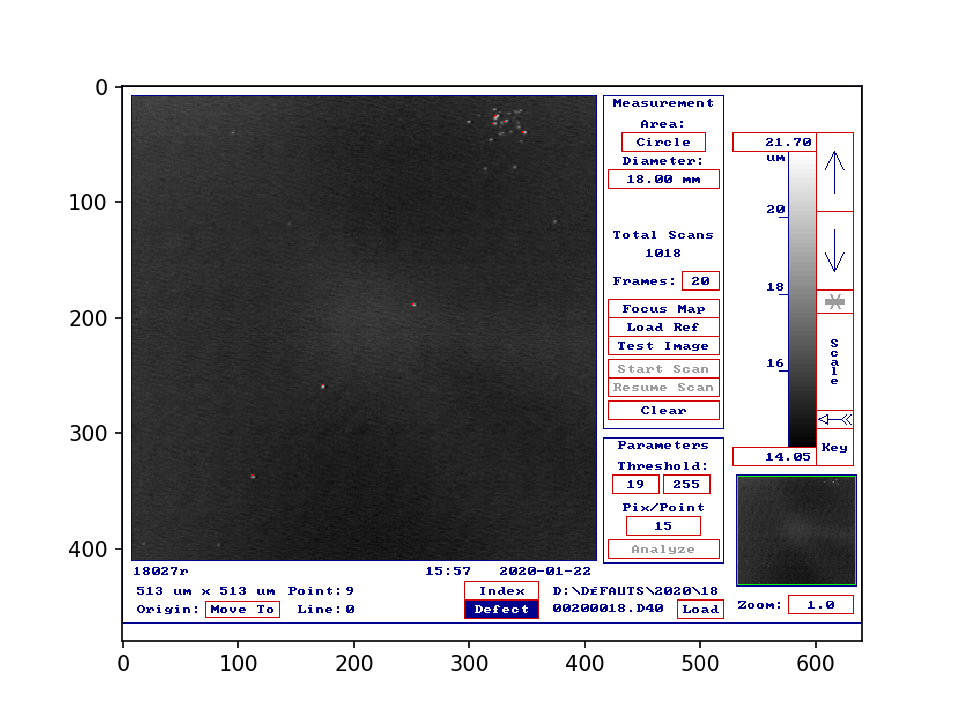

In [65]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.imshow(img)

## Image preprocessing

Zoom in the interesting region to remove the interface, by selecting the pixel range of the region. I did that fast, so please cross-check the range to make sure the whole image is there. 

<IPython.core.display.Javascript object>


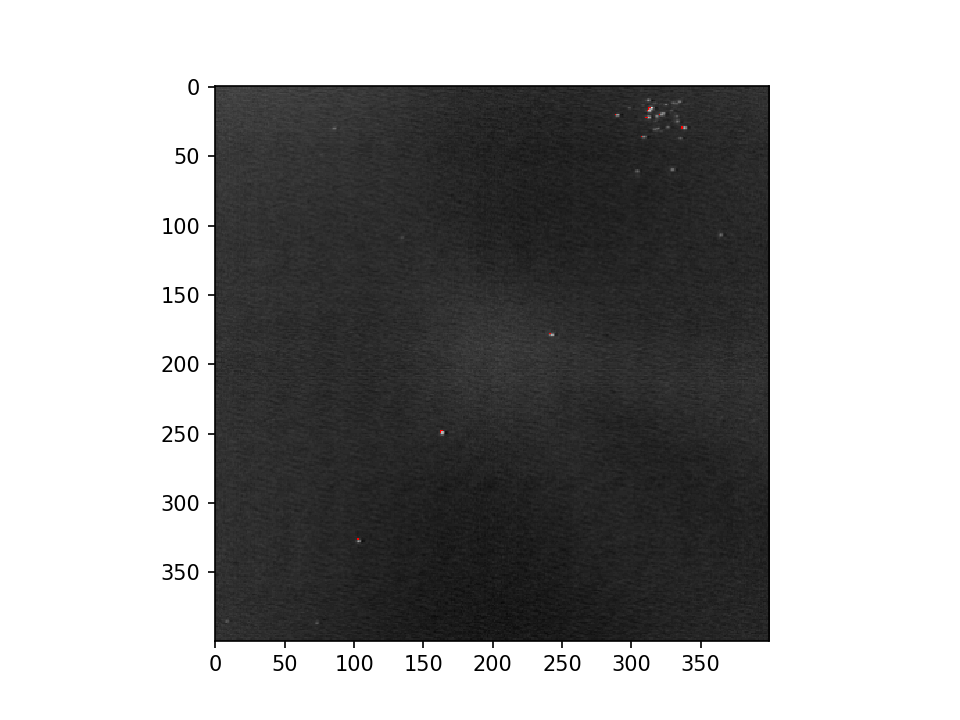

In [66]:
imz = img[10:410, 10:410]
plt.figure(dpi=150)
plt.imshow(imz)

Conversion to grayscale. We're going to lose the information from the colored pixels by doing this, but you can think later how to extract this info before conversion to greyscale. After conversion, the image has only 1 color channel per pixel. It is diplayed with a given colormap, but this is still greyscale.

(400, 400)


<IPython.core.display.Javascript object>


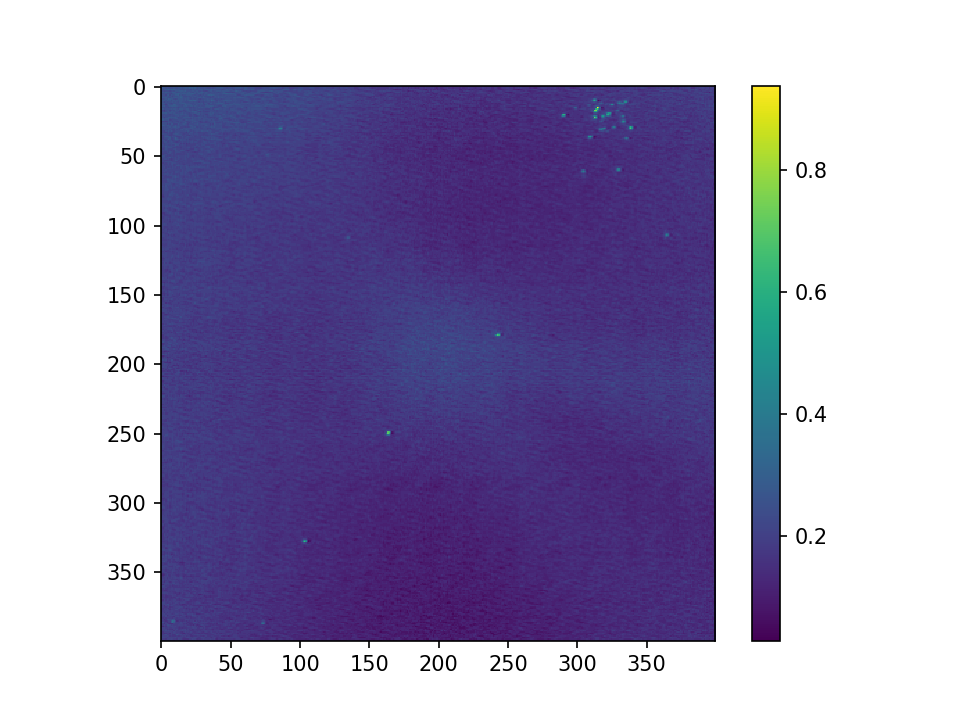

In [67]:
from skimage.color import rgb2gray
imbw = rgb2gray(imz)
print(imbw.shape)
plt.figure(dpi=150)
plt.imshow(imbw)
plt.colorbar()

## Detect defects

We start by using the [Laplacian of Gaussian algorithm](https://en.wikipedia.org/wiki/Blob_detection#The_Laplacian_of_Gaussian), as implemented in [scikit-image](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log). 

In [68]:
from skimage.feature import blob_log
blobs_log = blob_log(imbw, max_sigma=5, min_sigma=1, num_sigma=200, threshold=0.04)

blob_logs contains, for each defect found, x, y, and sigma. We replace sigma by the corresponding radius to be able to plot the defects later on: 

In [69]:
import math
blobs_log[:, 2] = blobs_log[:, 2] * math.sqrt(2)
blobs_log

array([[387.        ,  73.        ,   1.41421356],
       [385.        ,   8.        ,   1.47106637],
       [328.        , 103.        ,   1.41421356],
       [250.        , 163.        ,   1.41421356],
       [179.        , 242.        ,   1.41421356],
       [109.        , 134.        ,   1.41421356],
       [107.        , 364.        ,   1.41421356],
       [ 61.        , 304.        ,   1.41421356],
       [ 60.        , 329.        ,   1.49949277],
       [ 37.        , 335.        ,   1.41421356],
       [ 36.        , 309.        ,   1.41421356],
       [ 31.        , 317.        ,   1.64162479],
       [ 30.        , 338.        ,   1.41421356],
       [ 30.        , 319.        ,   1.41421356],
       [ 30.        ,  86.        ,   1.41421356],
       [ 29.        , 326.        ,   1.41421356],
       [ 25.        , 333.        ,   1.41421356],
       [ 25.        , 317.        ,   1.41421356],
       [ 22.        , 312.        ,   1.41421356],
       [ 21.        , 332.     

<IPython.core.display.Javascript object>


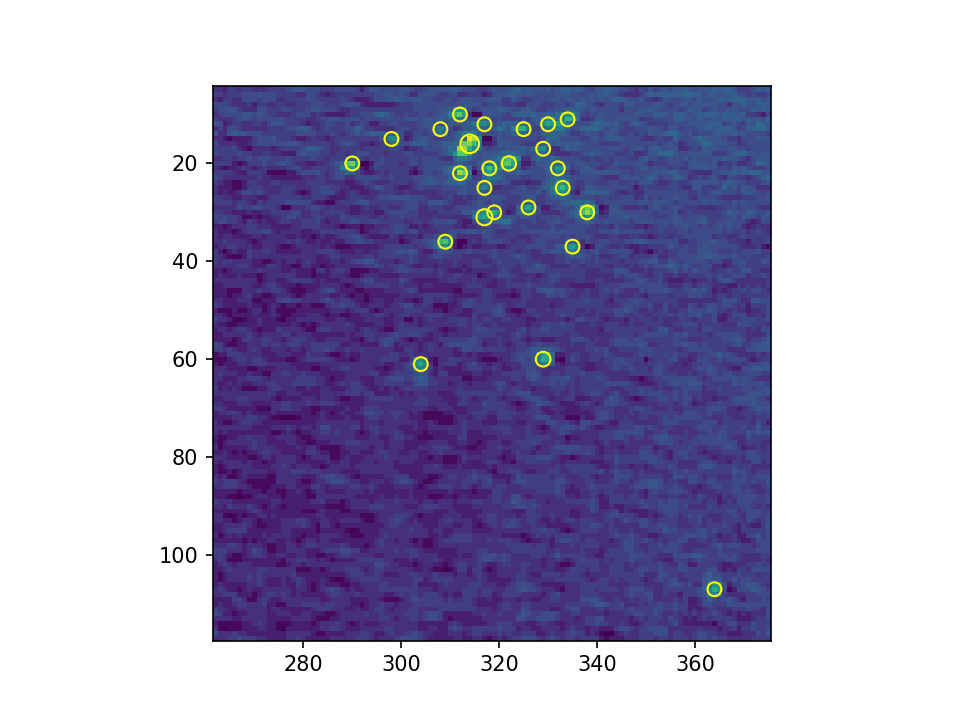

In [73]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1, dpi=150)
plt.imshow(imbw, 
           norm=LogNorm(vmin=0.1, vmax=1)
          )
ax.set_aspect('equal')
for blob in blobs_log: 
    y, x, r = blob 
    circle = plt.Circle((x, y), r, color='yellow', linewidth=1, fill=False)
    ax.add_patch(circle)

## Next steps: 

### You 

* tell me how many images you will need to process
* try many different images, and see if the algorithm behaves properly
* think how to tune the algorithm
* possibly try other algorithms 
* find the location of the colored images and keep track of this. For example for red:

In [71]:
red = imz[:,:,0]>0.999
print(red.shape)
np.sum(red)

(400, 400)


17

<IPython.core.display.Javascript object>


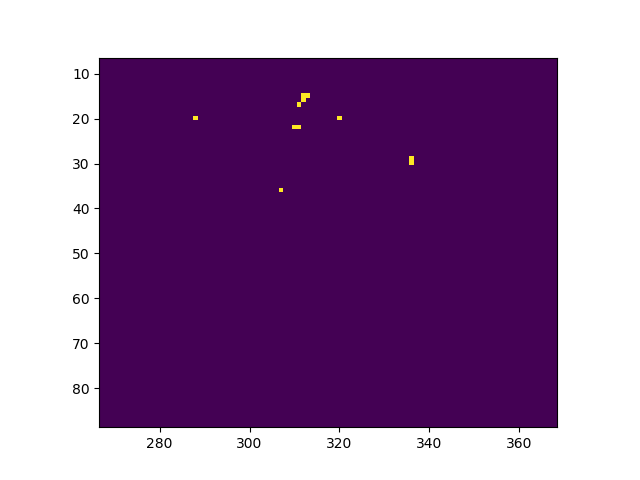

In [72]:
plt.figure()
plt.imshow(red)

### Me

* think about parallelization. We can process all images on the IPNL cluster in parallel easily. 
* prepare for building and storing meta information: database, etc. 

I can make proposals and help you built prototypes, but it would be good to have an IR or IE take over from here. 
